In [1]:
import numpy as np
from abc import ABC, abstractmethod
from typing import List, Callable


class Layer(ABC):
    @abstractmethod
    def forward(self, x: np.ndarray, is_train: bool = True) -> np.ndarray:
        pass

    @abstractmethod
    def backward(self, dx: np.ndarray) -> np.ndarray:
        pass


class Linear(Layer):
    def __init__(self, input_size: int, output_size: int, lr_rate: float = 0.001):
        self.w = np.random.randn(input_size, output_size) * np.sqrt(2. / (input_size + output_size))
        self.b = np.zeros(output_size)
        self.lr_rate = lr_rate
        self.x = None

    def forward(self, x: np.ndarray, is_train: bool = True) -> np.ndarray:
        if is_train:
            self.x = x.copy()
        return np.dot(x, self.w) + self.b

    def backward(self, dx: np.ndarray) -> np.ndarray:
        dw = np.dot(self.x.T, dx)
        db = np.sum(dx, axis=0)
        dw += 0.001 * self.w  

        self.w -= self.lr_rate * dw
        self.b -= self.lr_rate * db

        return np.dot(dx, self.w.T)


class ReLU(Layer):
    def __init__(self):
        self.mask = None

    def forward(self, x: np.ndarray, is_train: bool = True) -> np.ndarray:
        if is_train:
            self.mask = (x > 0)
        return np.maximum(0, x)

    def backward(self, dx: np.ndarray) -> np.ndarray:
        return dx * self.mask


class MSELoss:
    def __call__(self, predictions: np.ndarray, targets: np.ndarray) -> float:
        self.predictions = predictions
        self.targets = targets
        loss = np.mean((predictions - targets) ** 2)
        return loss

    def backward(self) -> np.ndarray:
        return 2 * (self.predictions - self.targets) / self.predictions.shape[0]


In [2]:
class Model:
    class Mode:
        Train = 1
        Eval = 2

    def __init__(self, layers: List[Layer], loss: Callable[[np.ndarray, np.ndarray], float]):
        self.layers = layers
        self.loss_fn = loss
        self._mode = self.Mode.Train

    @property
    def mode(self):
        return self._mode

    @mode.setter
    def mode(self, value):
        self._mode = value

    def predict(self, x: np.ndarray) -> np.ndarray:
        out = x
        for layer in self.layers:
            out = layer.forward(out, is_train=self._mode == self.Mode.Train)
        return out

    def loss(self, predictions: np.ndarray, targets: np.ndarray) -> float:
        return self.loss_fn(predictions, targets)

    def backward(self):
        grad = self.loss_fn.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.predict(x)


Epoch 0: Train Loss = 177.1955, Test Loss = 174.8839
Epoch 10: Train Loss = 88.6745, Test Loss = 88.8499
Epoch 20: Train Loss = 21.2096, Test Loss = 24.2875
Epoch 30: Train Loss = 9.3444, Test Loss = 12.1337
Epoch 40: Train Loss = 7.0955, Test Loss = 9.4113
Epoch 50: Train Loss = 5.7961, Test Loss = 7.9227
Epoch 60: Train Loss = 4.9134, Test Loss = 6.9248
Epoch 70: Train Loss = 4.2821, Test Loss = 6.2169
Epoch 80: Train Loss = 3.8182, Test Loss = 5.6999
Epoch 90: Train Loss = 3.4686, Test Loss = 5.3152
Epoch 100: Train Loss = 3.2001, Test Loss = 5.0252


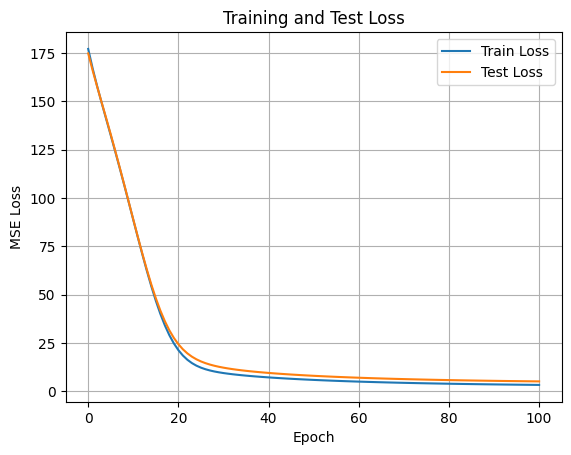

Средняя абсолютная ошибка: 1.58


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = pd.read_csv("student/student-por.csv", sep=";")
y = df.pop("G3").values.reshape(-1, 1)
X = pd.get_dummies(df).values

# Стандартизация
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Параметры модели
input_size = X.shape[1]
learning_rate = 0.001
n_epochs = 100

model = Model(
    layers=[
        Linear(input_size, 128, lr_rate=learning_rate),
        ReLU(),
        Linear(128, 64, lr_rate=learning_rate),
        ReLU(),
        Linear(64, 1, lr_rate=learning_rate)
    ],
    loss=MSELoss()
)

# Обучение
train_loss_history = []
test_loss_history = []

for epoch in range(n_epochs + 1):
    model.mode = Model.Mode.Train
    preds = model(X_train)
    loss = model.loss(preds, y_train)
    train_loss_history.append(loss)
    model.backward()

    model.mode = Model.Mode.Eval
    test_preds = model(X_test)
    test_loss = model.loss(test_preds, y_test)
    test_loss_history.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss:.4f}, Test Loss = {test_loss:.4f}")

# Графики
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

# MAE
mae = np.mean(np.abs(test_preds - y_test))
print(f"Средняя абсолютная ошибка: {mae:.2f}")


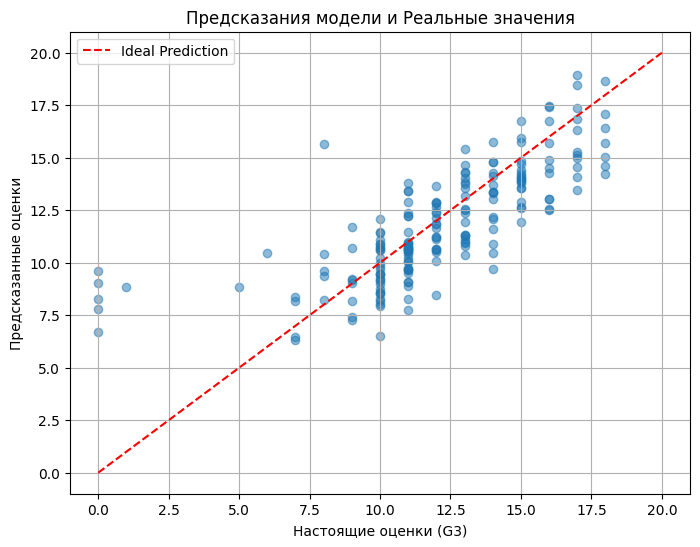

In [4]:
# График: Предсказания vs Настоящие значения
import matplotlib.pyplot as plt

y_true = y_test.flatten()
y_pred = test_preds.flatten()

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 20], [0, 20], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel("Настоящие оценки (G3)")
plt.ylabel("Предсказанные оценки")
plt.title("Предсказания модели и Реальные значения")
plt.legend()
plt.grid()
plt.show()
